In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.preprocessing import StandardScaler

from numpy import mean
from numpy import std
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from xgboost import XGBRFClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from skopt import forest_minimize

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/students-dropout/sample_submission.csv
/kaggle/input/students-dropout/validation.csv
/kaggle/input/students-dropout/train.csv
/kaggle/input/students-dropout/test.csv


### Setting up the dfs

In [2]:
# to train:
train_df = pd.read_csv('/kaggle/input/students-dropout/train.csv')
# to test:
val_df = pd.read_csv('/kaggle/input/students-dropout/validation.csv')
# to predict:
test_df = pd.read_csv('/kaggle/input/students-dropout/test.csv')

sample_df = pd.read_csv('/kaggle/input/students-dropout/sample_submission.csv')

# EDA 

In [3]:
train_df.describe()

,Id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
count,2476.000000,2476.000000,2476.000000,2476.000000,2476.000000,2476.000000,2476.000000,2476.000000,2476.000000,2476.000000,...,2476.000000,2476.000000,2476.000000,2476.000000,2476.000000,2476.000000,2476.000000,2476.000000,2476.000000,2476.000000
mean,2211.848142,1.176494,6.865105,1.722940,9.912763,0.885299,2.457997,1.237480,12.121163,16.460420,...,0.125202,0.553716,6.207997,8.068255,4.466074,10.287523,0.142973,11.558522,1.227181,0.049935
std,1279.257993,0.600966,5.261983,1.304837,4.348326,0.318725,3.878489,1.685393,9.019925,11.009475,...,0.651707,1.914945,2.209427,3.972810,2.987121,5.168928,0.709357,2.653639,1.368978,2.270650
min,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,1078.750000,1.000000,1.000000,1.000000,6.000000,1.000000,1.000000,1.000000,2.000000,3.000000,...,0.000000,0.000000,5.000000,6.000000,2.000000,10.833333,0.000000,9.400000,0.300000,-1.700000
50%,2218.000000,1.000000,8.000000,1.000000,10.000000,1.000000,1.000000,1.000000,13.000000,14.000000,...,0.000000,0.000000,6.000000,8.000000,5.000000,12.221825,0.000000,11.100000,1.400000,0.320000
75%,3319.250000,1.000000,12.000000,2.000000,13.000000,1.000000,1.000000,1.000000,22.000000,27.000000,...,0.000000,0.000000,7.000000,10.000000,6.000000,13.369375,0.000000,13.900000,2.600000,1.790000
max,4420.000000,6.000000,18.000000,6.000000,17.000000,1.000000,17.000000,20.000000,28.000000,34.000000,...,12.000000,18.000000,23.000000,27.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000


In [4]:
train_df.isnull().sum()
#train_df.dtypes

Id                                                0
Marital status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance                        0
Previous qualification                            0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                                0
Age at enrollment                                 0
Internationa

In [5]:
### Understading the target

In [6]:
train_df['Category'].unique()

array(['Graduate', 'Dropout', 'Enrolled'], dtype=object)

### Defining the most impacting featres

In [7]:
train_df.columns

Index(['Id', 'Marital status', 'Application mode', 'Application order',
       'Course', 'Daytime/evening attendance', 'Previous qualification',
       'Nacionality', 'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Displaced',
       'Educational special needs', 'Debtor', 'Tuition fees up to date',
       'Gender', 'Scholarship holder', 'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)',
       'Curricular units 2nd sem (without evalua

In [8]:
numerical = [ 'Age at enrollment',
'Unemployment rate',
'Previous qualification',
'Inflation rate',
'GDP',
'Curricular units 1st sem (approved)',
'Curricular units 2nd sem (approved)',
'Curricular units 1st sem (grade)',
'Curricular units 2nd sem (grade)',
'Curricular units 1st sem (evaluations)',
'Curricular units 2nd sem (evaluations)',
'Curricular units 1st sem (enrolled)',
'Curricular units 2nd sem (enrolled)']

Age at enrollment


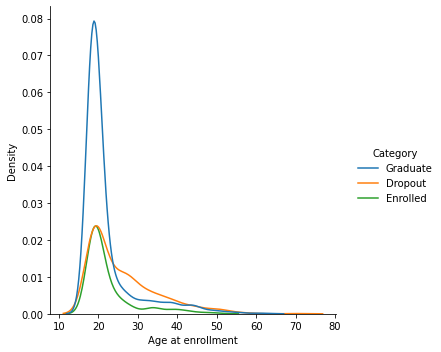

Unemployment rate


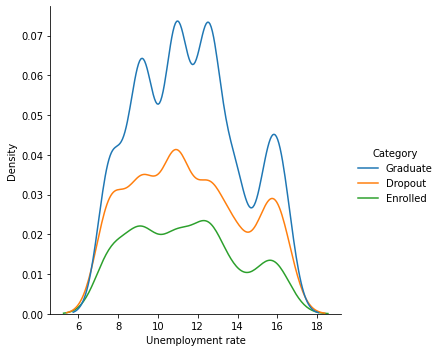

Previous qualification


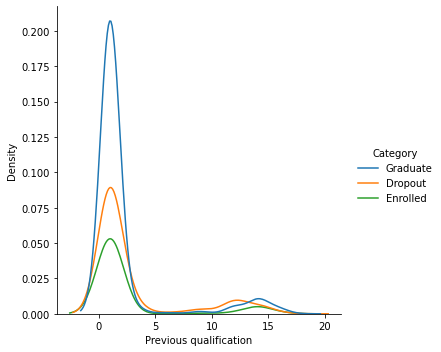

Inflation rate


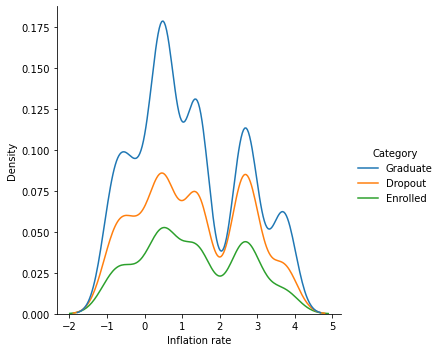

GDP


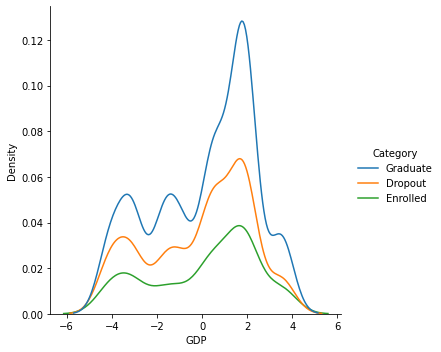

Curricular units 1st sem (approved)


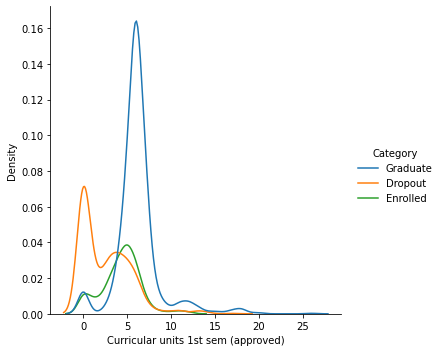

Curricular units 2nd sem (approved)


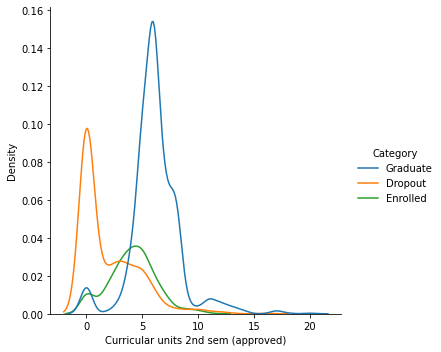

Curricular units 1st sem (grade)


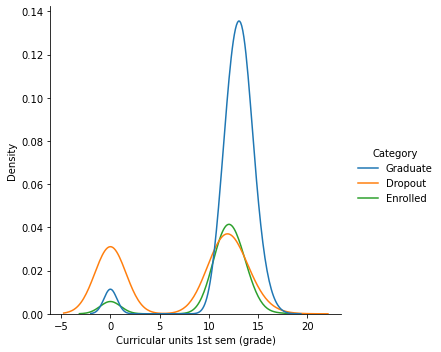

Curricular units 2nd sem (grade)


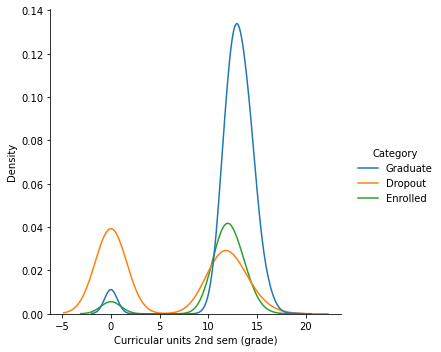

Curricular units 1st sem (evaluations)


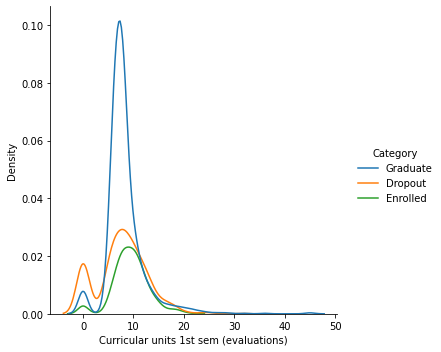

Curricular units 2nd sem (evaluations)


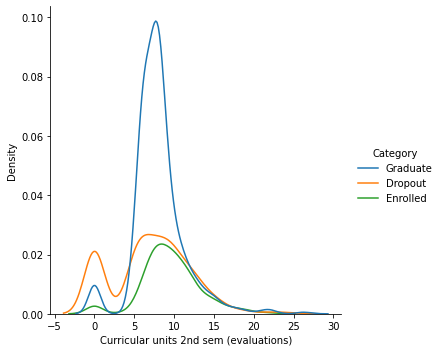

Curricular units 1st sem (enrolled)


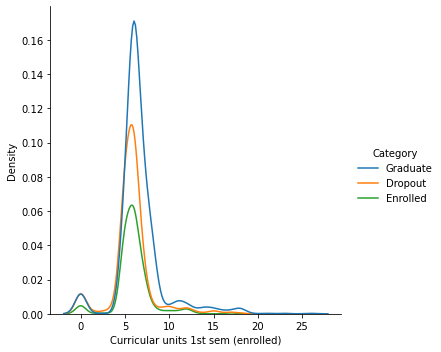

Curricular units 2nd sem (enrolled)


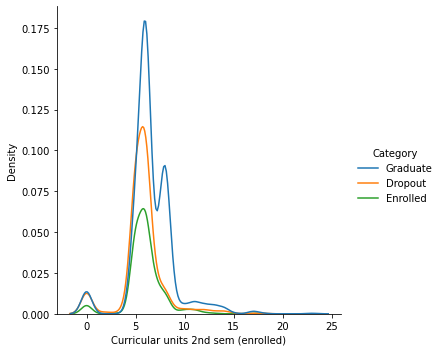

In [9]:
# exploring the numerical feaures
for feature in numerical:
    print(f'{feature}')
    sns.displot(data=train_df, x=feature, hue= 'Category', kind="kde")
    plt.show()

In [10]:
bools = ['Scholarship holder',
'Debtor',
'Tuition fees up to date',
'Gender',
'Displaced']

Scholarship holder


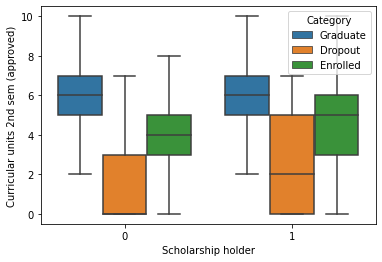

Debtor


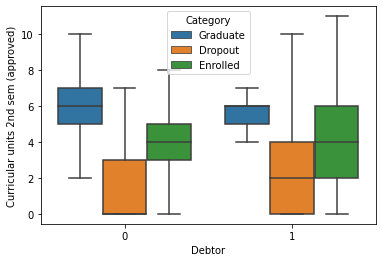

Tuition fees up to date


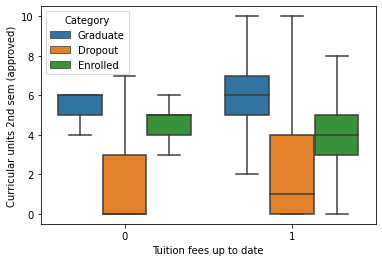

Gender


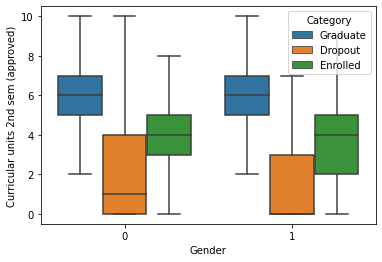

Displaced


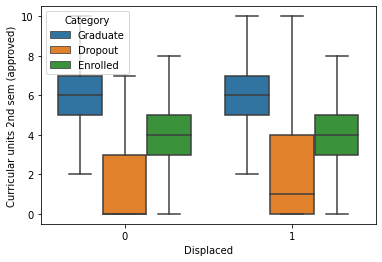

In [11]:
# exploring the bool columns
for feature in bools:
    print(f'{feature}')
    sns.boxplot(data=train_df, x=feature,y='Curricular units 2nd sem (approved)', hue= 'Category', showfliers=False)
    plt.show()

In [12]:
# exploring the categorical columns
categorical = ['Application mode',
'Course',
"Mother's qualification",
"Father's qualification",
"Father's occupation"]

Application mode


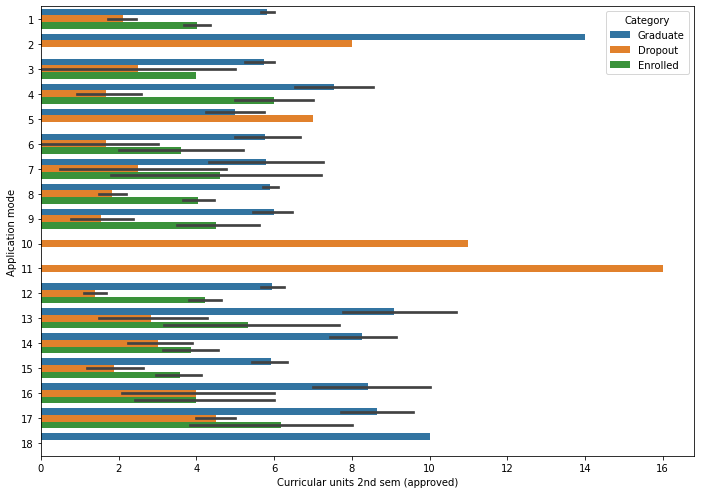

Course


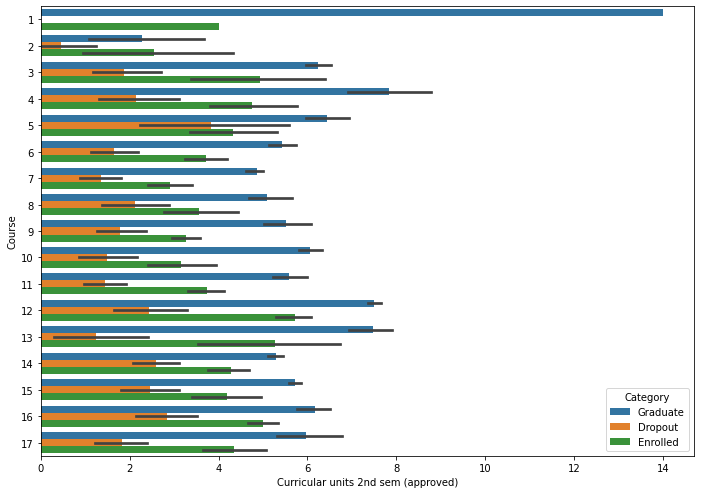

Mother's qualification


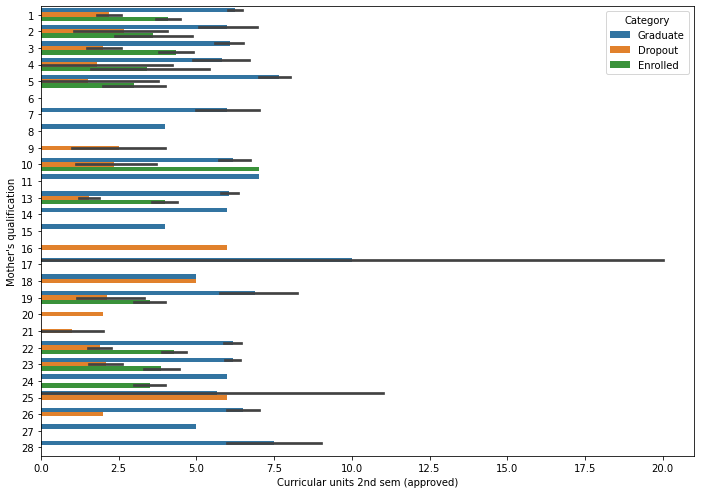

Father's qualification


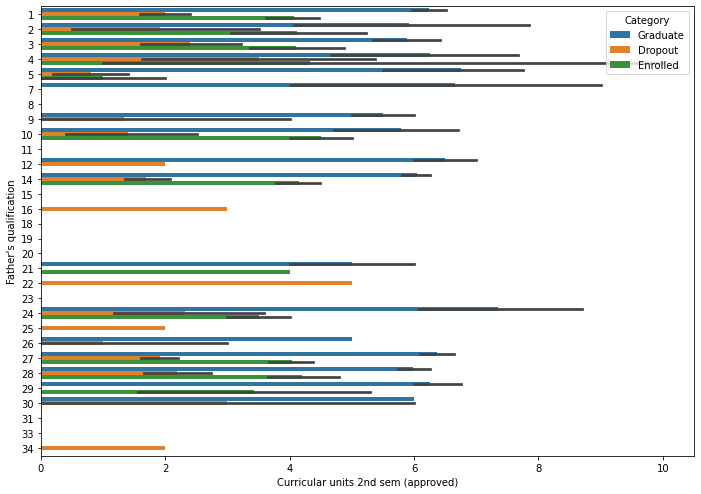

Father's occupation


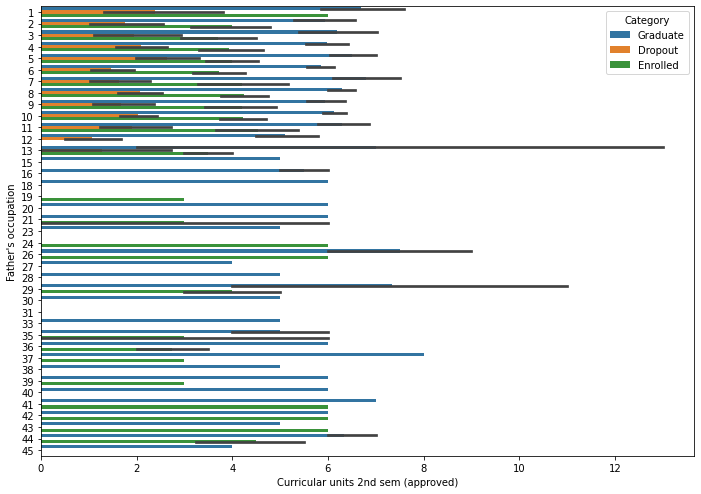

In [13]:

rcParams['figure.figsize'] = 11.7,8.27

for feature in categorical:
    print(f'{feature}')
    sns.barplot(data=train_df, y=feature,x='Curricular units 2nd sem (approved)', hue= 'Category', orient = 'h')#, showfliers=False )
    plt.show()
    

### Setting up y in numeric values for X models : xgboost and xgbrf

Graduate: 2, 

Enrolled: 1, 

Dropout: 0


In [14]:
train_df['Category'].replace({'Graduate': 2, 'Enrolled': 1, 'Dropout': 0}, inplace = True)
val_df['Category'].replace({'Graduate': 2, 'Enrolled': 1, 'Dropout': 0}, inplace = True)
train_df

,Id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Category
0,3222,1,1,1,14,1,1,1,13,28,...,0,6,7,6,14.714286,0,11.1,0.6,2.02,2
1,2388,1,8,4,9,1,1,1,23,14,...,0,5,10,2,12.500000,0,11.1,0.6,2.02,0
2,1865,1,12,1,17,0,1,1,1,1,...,0,5,5,5,12.400000,0,15.5,2.8,-4.06,2
3,652,1,12,1,12,1,12,1,1,5,...,0,8,11,7,12.614286,0,12.7,3.7,-1.70,2
4,4220,1,1,1,14,1,1,1,19,28,...,0,5,5,0,0.000000,0,9.4,-0.8,-3.12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2471,4286,1,1,1,6,1,1,1,22,14,...,0,5,9,4,13.666667,1,10.8,1.4,1.74,2
2472,4399,1,1,1,11,1,1,1,22,14,...,0,6,6,6,14.333333,0,9.4,-0.8,-3.12,2
2473,3526,2,12,1,4,1,1,1,1,3,...,2,7,7,5,11.200000,0,8.9,1.4,3.51,0
2474,1050,1,1,1,2,1,1,1,1,28,...,0,0,0,0,0.000000,0,13.9,-0.3,0.79,2


In [15]:
# One hot encoding to calculate recall on the dropout
train_dummies = pd.get_dummies(train_df['Category'], prefix='Label')
train_dummies.rename(columns={'Label_0': 'Dropout', 'Label_1': 'Enrolled', 'Label_2': 'Graduate'}, inplace=True) 
y_train = train_dummies.Dropout
y_train

0       0
1       1
2       0
3       0
4       1
       ..
2471    0
2472    0
2473    1
2474    0
2475    1
Name: Dropout, Length: 2476, dtype: uint8

In [16]:
train_df_d = train_df.join(train_dummies)
train_df_d

,Id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Category,Dropout,Enrolled,Graduate
0,3222,1,1,1,14,1,1,1,13,28,...,6,14.714286,0,11.1,0.6,2.02,2,0,0,1
1,2388,1,8,4,9,1,1,1,23,14,...,2,12.500000,0,11.1,0.6,2.02,0,1,0,0
2,1865,1,12,1,17,0,1,1,1,1,...,5,12.400000,0,15.5,2.8,-4.06,2,0,0,1
3,652,1,12,1,12,1,12,1,1,5,...,7,12.614286,0,12.7,3.7,-1.70,2,0,0,1
4,4220,1,1,1,14,1,1,1,19,28,...,0,0.000000,0,9.4,-0.8,-3.12,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2471,4286,1,1,1,6,1,1,1,22,14,...,4,13.666667,1,10.8,1.4,1.74,2,0,0,1
2472,4399,1,1,1,11,1,1,1,22,14,...,6,14.333333,0,9.4,-0.8,-3.12,2,0,0,1
2473,3526,2,12,1,4,1,1,1,1,3,...,5,11.200000,0,8.9,1.4,3.51,0,1,0,0
2474,1050,1,1,1,2,1,1,1,1,28,...,0,0.000000,0,13.9,-0.3,0.79,2,0,0,1


In [17]:
# ['Category', 'Dropout', 'Enrolled', 'Graduate'] y_train
#y_train = train_df_d['Dropout']
#y_train

In [18]:
# One hot encoding to calculate recall on the dropout
val_dummies = pd.get_dummies(val_df['Category'], prefix='Label')
val_dummies.rename(columns={'Label_0': 'Dropout', 'Label_1': 'Enrolled', 'Label_2': 'Graduate'}, inplace=True) 
y_val = val_dummies.Dropout
y_val

0       1
1       0
2       0
3       0
4       1
       ..
1323    0
1324    0
1325    0
1326    0
1327    0
Name: Dropout, Length: 1328, dtype: uint8

In [19]:
#dataset_dummies["Label_0.0", "Label_1.0", "Label_2.0"] = dataset_dummies["Dropout", "Enrolled", "Graduate"]#.astype(bool)


### Setting X For train and validation

In [20]:
#X_test = validation_df[features]
X_train = train_df.drop(columns=['Category'])
X_val = val_df.drop(columns=['Category'])
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)

### Setting X with relevant features

In [21]:
# relevant features
features = ['Application mode',
'Course',
'Scholarship holder',
'Curricular units 1st sem (approved)',
'Curricular units 2nd sem (approved)',
'Curricular units 1st sem (grade)',
'Curricular units 2nd sem (grade)',

'Debtor',
'Curricular units 2nd sem (evaluations)',
'Curricular units 1st sem (evaluations)',
'Tuition fees up to date',
'Gender',
'Age at enrollment',
'Curricular units 1st sem (enrolled)',
'Curricular units 2nd sem (enrolled)',
'Unemployment rate',

'Displaced',
"Mother's qualification",
"Father's qualification",
"Father's occupation",
'Previous qualification',
'Inflation rate',
'GDP']

In [22]:
X_train_selected =  train_df[features]
X_val_selected = val_df[features]
# Scaling the values to improve performance
X_train_selected = sc.fit_transform(X_train)
X_val_selected = sc.fit_transform(X_val)
X_train_selected

array([[ 0.78979839, -0.29374363, -1.11484397, ..., -0.17282475,
        -0.45823055,  0.86779657],
       [ 0.13772628, -0.29374363,  0.21572177, ..., -0.17282475,
        -0.45823055,  0.86779657],
       [-0.27118705, -0.29374363,  0.97604505, ...,  1.48561085,
         1.14913209, -1.81039128],
       ...,
       [ 1.02748415,  1.37057954,  0.97604505, ..., -1.00204255,
         0.12626496,  1.52412878],
       [-0.90840381, -0.29374363, -1.11484397, ...,  0.88254336,
        -1.11578799,  0.32599212],
       [-0.5612575 , -0.29374363,  0.97604505, ...,  1.74945288,
        -0.67741636, -0.42724821]])

## Implementation of relevant machine learning models.
### I decided to use the "recall" metric because we are mostly interested in the students that dropped their studies or may want to do it


In [23]:
# choosing the model
gbc = GradientBoostingClassifier()
xgbc = XGBClassifier()
XGBRFC = XGBRFClassifier()
rfc = RandomForestClassifier()
hgbc = HistGradientBoostingClassifier()

# setting the cross validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model 1
n_scores = cross_val_score(gbc, X_train, y_train, scoring='recall', cv=cv, n_jobs=-1)
# evaluate the model 2
n_scores1 = cross_val_score(xgbc, X_train, y_train, scoring='recall', cv=cv, n_jobs=-1)
# evaluate the model 3
n_scores2 = cross_val_score(XGBRFC, X_train, y_train, scoring='recall', cv=cv, n_jobs=-1)
# evaluate the model 4
n_scores3 = cross_val_score(rfc, X_train, y_train, scoring='recall', cv=cv, n_jobs=-1)
# evaluate the model 4
n_scores4 = cross_val_score(hgbc, X_train, y_train, scoring='recall', cv=cv, n_jobs=-1)

# report performance of the models
print('gbc Recall: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
print('hgbc Recall: %.3f (%.3f)' % (mean(n_scores4), std(n_scores4)))
print('xgbc Recall: %.3f (%.3f)' % (mean(n_scores1), std(n_scores1)))
print('rfc Recall: %.3f (%.3f)' % (mean(n_scores3), std(n_scores3)))
print('xgbrf Recall: %.3f (%.3f)' % (mean(n_scores2), std(n_scores2)))


gbc Recall: 0.731 (0.048)
hgbc Recall: 0.732 (0.054)
xgbc Recall: 0.725 (0.050)
rfc Recall: 0.705 (0.052)
xgbrf Recall: 0.695 (0.051)


# Recall

### gbc Recall: 0.731 (0.049)
### hgbc Recall: 0.732 (0.054)
### xgbc Recall: 0.725 (0.050)
### rfc Recall: 0.700 (0.050)
### xgbrf Recall: 0.695 (0.051)

### Checking if the feture selection as lead to any loss of informations:

In [24]:
# selected features
gbc = GradientBoostingClassifier().fit(X_train_selected, y_train)
gbc.score(X_val, y_val) #0.8667168674698795

0.8719879518072289

In [25]:
# all the features
gbc = GradientBoostingClassifier().fit(X_train, y_train)
gbc.score(X_val, y_val) #0.8712349397590361

0.8719879518072289

In [26]:
gbc.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

### Checking the most important features


In [27]:
def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Category'])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, dtrain[predictors], dtrain['Category'], cv=cv_folds, scoring='roc_auc')
  
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % accuracy_score(dtrain['Category'].values, dtrain_predictions))
    #print("AUC Score (Train): %f" % roc_auc_score(dtrain['Category'], dtrain_predprob, multi_class="ovr",average='macro'))

    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 349, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  UserWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most


Model Report
Accuracy : 0.8534
CV Score : Mean - nan | Std - nan | Min - nan | Max - nan


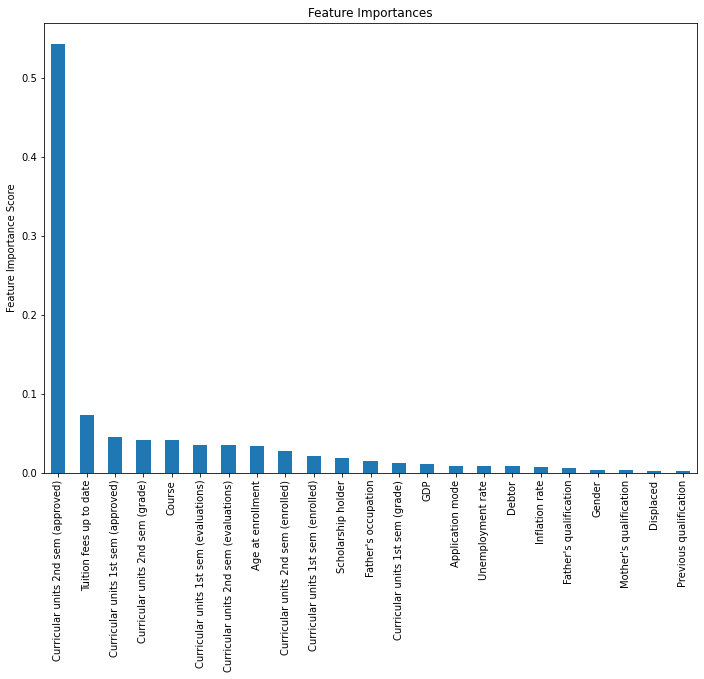

In [28]:
#Choose all predictors except target & IDcols
#predictors = X_train_selected.columns
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, train_df, features)

# Bayesian Optimization.

In [29]:
# Function for hyperparamters tunning
# Implementation learned on a lesson of Mario Filho (Kagle Grandmaster) for parametes optmization.
# Link to the video: https://www.youtube.com/watch?v=WhnkeasZNHI
def tune_gbc(params):
    """Function to be passed as scikit-optimize minimizer/maximizer   input
    
    Parameters:
    Tuples with information about the range that the optimizer should use for that parameter, 
    as well as the behavior that it should follow in that range.
    
    Returns:
    float: the metric that should be minimized. If the objective is maximization, then the negative 
    of the desired metric must be returned. In this case, the negative AUC average generated by CV is returned.
    """
    
    
    #Hyperparameters to be optimized
    print(params)
    learning_rate = params[0] 
    n_estimators = params[1] 
    max_depth = params[2]
    subsample = params[3]
    max_features = params[4]
    #learning_rate = params[5]
    #colsample_bytree = params[6]
        
    
    #Model to be optimized
    mdl = GradientBoostingClassifier(learning_rate = learning_rate,                        
    n_estimators = n_estimators, max_depth = max_depth, 
    subsample = subsample, max_features = max_features) # min_child_weight = min_child_weight, gamma = gamma, colsample_bytree = colsample_bytree, seed = 42
#Cross-Validation in order to avoid overfitting 
    f1 = cross_val_score(mdl, X_train_selected, y_train, 
    cv = 5,    scoring = "f1")
    
    print(f1.mean())
    # as the function is minimization (forest_minimize), we need to use the negative of the desired metric (AUC)
    return -f1.mean()

In [ ]:
# Creating a sample space in which the initial randomic search should be performed
space = [(1e-3, 1e-1, 'log-uniform'), # learning rate
          (100, 2000), # n_estimators
          (1, 10), # max_depth 
           (0.1,1), # subsample 
           (0,0.9), #max_features
          (0, 0.5)] # learning_rate 
          # (0.5, 1.)] # colsample_bytree

# Minimization using a random forest with 20 random samples and 50 iterations for Bayesian optimization.
n_calls = 40
result = forest_minimize(tune_gbc, space, random_state=42, n_calls=n_calls, n_random_starts=int(n_calls/2), verbose=1)

Iteration No: 1 started. Evaluating function at random point.
[0.03918194347141743, 1394, 8, 0.638792635777333, 0.1404167763981929, 0.07799726016810134]
0.9139335621378966
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 85.2807
Function value obtained: -0.9139
Current minimum: -0.9139
Iteration No: 2 started. Evaluating function at random point.
[0.0013066739238053284, 187, 5, 0.6410035105688879, 0.637265320016441, 0.010292247147901225]
0.9123503190995452
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 10.1326
Function value obtained: -0.9124
Current minimum: -0.9139
Iteration No: 3 started. Evaluating function at random point.
[0.08706020878304858, 1615, 6, 0.1007008892569129, 0.8929904033620959, 0.3087407548138583]
0.6447895001455374
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 42.4942
Function value obtained: -0.6448
Current minimum: -0.9139
Iteration No: 4 started. Evaluating function at random point.
[0.016722697006183

In [ ]:
print(result)

In [ ]:
# Hyperparameters optimized values
hyperparameters = ['learning_rate', 'n_estimators', 'max_depth', 'subsample', 'max_features'] #, 'min_child_weight', 'gamma', 'colsample_bytree'
h_dict = {}
for i in range(0, len(hyperparameters)): 
    h_dict[hyperparameters[i]] = result.x[i]
    print('{}: {}'.format(hyperparameters[i], result.x[i]))
h_dict

learning_rate: 0.004589824181495648

n_estimators: 1171

max_depth: 7

subsample: 0.379884089544096

max_features: 0.2926649898240724

In [ ]:
learning_rate = h_dict['learning_rate'] #0.008580760619921307 #0.007650167723698728
n_estimators = h_dict['n_estimators'] #1608 # 1645
max_depth = h_dict['max_depth'] #3 #2
subsample = h_dict['subsample'] #0.7122767847290018 # 0.985183888575587 # ??? between 0 and 1
max_features = h_dict['max_features'] #0.4504992519695431 #0.8
#all

gbcbo = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate ,max_depth= max_depth,
    max_features= max_features, subsample= subsample, random_state=42).fit(X_train, y_train)
#{'learning_rate': 1, 'max_depth': 5, 'max_features': 0.8, 'n_estimators': 120, 'subsample': 1}
# 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 
# 'max_depth': 5, 'max_features': 0.8, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 
# 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 120, 
# 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 
# 'verbose': 0, 'warm_start': False
gbcbo.score(X_val, y_val)
#0.749
#0.7469879518072289
# Baesian: 0.8682228915662651

In [ ]:
gbcbo.predict(X_val)


In [ ]:
#Choose all predictors except target & IDcols
modelfit(gbcbo, train_df, features)

### the most important features have really changed

## Model evaluation

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

### Creating a df merging train and validation sets

In [ ]:
#Setting up a merged df for the sake of the challenge (more train data)
df = pd.concat([train_df, val_df])
X = df.drop(columns=['Category'])
X = sc.fit_transform(X)
# keep consistency with y
y = df['Category']
y_num = y.replace({'Graduate': 2, 'Enrolled': 1, 'Dropout': 0})

print (df.shape)

In [ ]:
# evaluate xgboost algorithm for classification
y.value_counts()
X = sc.fit_transform(X)

### K Fold cross validation

### Standard gradient boosting

In [ ]:
kfold_validation = KFold(10)
results = cross_val_score(gbc, X,y, cv=kfold_validation)
print(results)
print(np.mean(results))

### Tuned gradient boosting

In [ ]:
results = cross_val_score(gbcbo, X,y, cv=kfold_validation)
print(results)
print(np.mean(results))

In [ ]:
y_pred = gbcbo.predict(test_df)

#print(len(y_target))

#xpected 'Id' column to be of type 'Int32', but was 'String'
#ERROR: Unable to convert 'Id' column row 51 value 'Graduate' to expected type 'Int32'
#ERROR: Unable to convert 'Id' column row 333 value 'Enrolled' to expected type 'Int32'
target_df = pd.DataFrame(test_df['Id'])
target_df['Id']=target_df['Id'].astype(int)
Category = y_pred.tolist()

target_df['Category'] = Category
target_df.sort_values(by=['Id'])

In [ ]:
# Setting a categorical y
target_df['Category'].replace({ 2:'Graduate', 1 : 'Enrolled', 0 : 'Dropout'}, inplace = True)
#print(target_df2.sort_values(by=['Id']))
target_df.to_csv('submission.csv',index=False)  

pd.read_csv('submission.csv').sort_values(by=['Id'])

In [ ]:
pd.read_csv('submission.csv')['Category'].unique()

# Let's train our model on a full df to submit the results

In [ ]:
gbcbof = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate ,max_depth= max_depth,
    max_features= max_features, subsample= subsample, random_state=42)


final = gbcbof.fit(X, y_num)

In [ ]:
test_df

In [ ]:
y_pred = final.predict(test_df)

#print(len(y_target))

#xpected 'Id' column to be of type 'Int32', but was 'String'
#ERROR: Unable to convert 'Id' column row 51 value 'Graduate' to expected type 'Int32'
#ERROR: Unable to convert 'Id' column row 333 value 'Enrolled' to expected type 'Int32'
target_df = pd.DataFrame(test_df['Id'])
target_df['Id']=target_df['Id'].astype(int)
Category = y_pred.tolist()

target_df['Category'] = Category
target_df.sort_values(by=['Id'])

# Creating a submission file

In [ ]:
# Setting a categorical y
target_df['Category'].replace({ 2:'Graduate', 1 : 'Enrolled', 0 : 'Dropout'}, inplace = True)
#print(target_df2.sort_values(by=['Id']))
target_df.to_csv('submission.csv',index=False)  

pd.read_csv('submission.csv').sort_values(by=['Id'])

In [ ]:
pd.read_csv('submission.csv')['Category'].unique()